## Example plot for LFPy: Single-synapse contribution to the EEG
* https://github.com/LFPy/LFPy/blob/master/examples/example_EEG.py

```
Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
```

In [1]:
import LFPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

--No graphics will be displayed.


In [2]:

def plot_cell_to_ax(cell, ax, synidxs):
    for idx in range(cell.totnsegs):
        if idx == 0:
            ax.plot(cell.x[idx].mean(), cell.z[idx].mean(), 'ko')
        else:
            ax.plot(cell.x[idx], cell.z[idx], c='k')

    for synidx in synidxs:
        l, = ax.plot(cell.x[synidx].mean(), cell.z[synidx].mean(), '*',
                     c="r", ms=10)
    ax.legend([l], ["Synapse"], frameon=False, bbox_to_anchor=[1, -0.1])

In [3]:

def plot_EEG_sphere(fig, eeg, x_eeg, y_eeg, z_eeg):
    ax = fig.add_subplot(322, projection='3d',
                         title="Max EEG potential\nat 4-sphere surface")
    vmax = 6
    vmin = -vmax

    def clr(phi):
        return plt.cm.PRGn((phi - vmin) / (vmax - vmin))

    clrs = clr(eeg)
    ax.plot_surface(x_eeg.reshape(num_theta, num_phi),
                    y_eeg.reshape(num_theta, num_phi),
                    z_eeg.reshape(num_theta, num_phi),
                    rstride=1, cstride=1, facecolors=clrs,
                    linewidth=0, antialiased=False)

    # ax.set_aspect('equal') # Raises NotImplementedError in MPL currently
    ax.axis('off')
    ax.set_xlim3d(-65000, 65000)
    ax.set_ylim3d(-65000, 65000)
    ax.set_zlim3d(-65000, 65000)
    ax.view_init(10, 0)

    # colorbar
    cax = fig.add_axes([0.65, 0.75, 0.25, 0.01])
    m = plt.cm.ScalarMappable(cmap=plt.cm.PRGn)
    ticks = np.linspace(vmin, vmax, 5)  # global normalization
    m.set_array(ticks)
    cbar = fig.colorbar(m, cax=cax,
                        extend='both', orientation='horizontal')
    cbar.outline.set_visible(False)
    cbar.set_ticks(ticks)
    cbar.set_label(r'$\phi$ (pV)', labelpad=1.)

In [4]:
radii = [79000., 80000., 85000., 90000.]
sigmas = [0.3, 1.5, 0.015, 0.3]
rad_tol = 1e-2

# simulate cell
syn_loc = (0, 0, 1000)

In [5]:
cell_params = {'morphology': 'morphologies/L5_Mainen96_LFPy.hoc',
                'cm': 1.0,  # membrane capacitance
                'Ra': 150,  # axial resistance
                'passive': True,  # switch on passive mechs
                # method for setting number of segments:
                'nsegs_method': 'lambda_f',
                # lambda frequency:
                'lambda_f': 100,
                # passive params:
                'passive_parameters': {'g_pas': 1. / 30000, 'e_pas': -70},
                'tstop': 40,  # simulation duration
                }

synapse_params = {'e': 0.,  # reversal potential
                    'syntype': 'ExpSyn',  # exponential synapse
                    'tau': 5.,  # synapse time constant
                    'weight': 0.001,  # 0.001, # synapse weight
                 'record_current': True  # record synapse current
                }

In [6]:
# create cell with parameters in dictionary
cell = LFPy.Cell(**cell_params)
cell.set_rotation(x=4.98919, y=-4.33261, z=0.)
pos = syn_loc
synapse_params['idx'] = cell.get_closest_idx(x=pos[0], y=pos[1], z=pos[2])
synapse = LFPy.Synapse(cell, **synapse_params)
synapse.set_spike_times(np.array([5.]))

cell.simulate(rec_imem=True)

In [7]:
# compute dipole
cdm = LFPy.CurrentDipoleMoment(cell)
P = cdm.get_transformation_matrix() @ cell.imem

In [8]:
somapos = np.array([0., 0., 77500])
r_soma_syns = [
    cell.get_intersegment_vector(
        idx0=0,
        idx1=i) for i in cell.synidx]
r_mid = np.average(r_soma_syns, axis=0)
r_mid = somapos + r_mid / 2.

eeg_coords_top = np.array([[0., 0., radii[3] - rad_tol]])
four_sphere_top = LFPy.FourSphereVolumeConductor(
    eeg_coords_top, radii, sigmas)
pot_db_4s_top = four_sphere_top.get_dipole_potential(P, r_mid)
eeg_top = np.array(pot_db_4s_top) * 1e9

In [9]:
# measurement points
# for nice plot use theta_step = 1 and phi_step = 1. NB: Long computation
# time.
theta_step = 5
phi_step = 5
theta, phi_angle = np.mgrid[0.:180.:theta_step,
                            0.:360. + phi_step:phi_step]

num_theta = theta.shape[0]
num_phi = theta.shape[1]
theta = theta.flatten()
phi_angle = phi_angle.flatten()

theta_r = np.deg2rad(theta)
phi_angle_r = np.deg2rad(phi_angle)

x_eeg = (radii[3] - rad_tol) * np.sin(theta_r) * np.cos(phi_angle_r)
y_eeg = (radii[3] - rad_tol) * np.sin(theta_r) * np.sin(phi_angle_r)
z_eeg = (radii[3] - rad_tol) * np.cos(theta_r)
eeg_coords = np.vstack((x_eeg, y_eeg, z_eeg)).T

In [10]:
# potential in 4S with db
time_max = np.argmax(np.linalg.norm(P, axis=0))
p = P[:, time_max].reshape((3, 1))

four_sphere = LFPy.FourSphereVolumeConductor(eeg_coords, radii, sigmas)
pot_db_4s = four_sphere.get_dipole_potential(p, r_mid)
eeg = pot_db_4s.reshape(num_theta, num_phi) * 1e9  # from mV to pV

P_mag = np.sqrt(P[:, 0]**2 + P[:, 1]**2 + P[:, 2]**2)

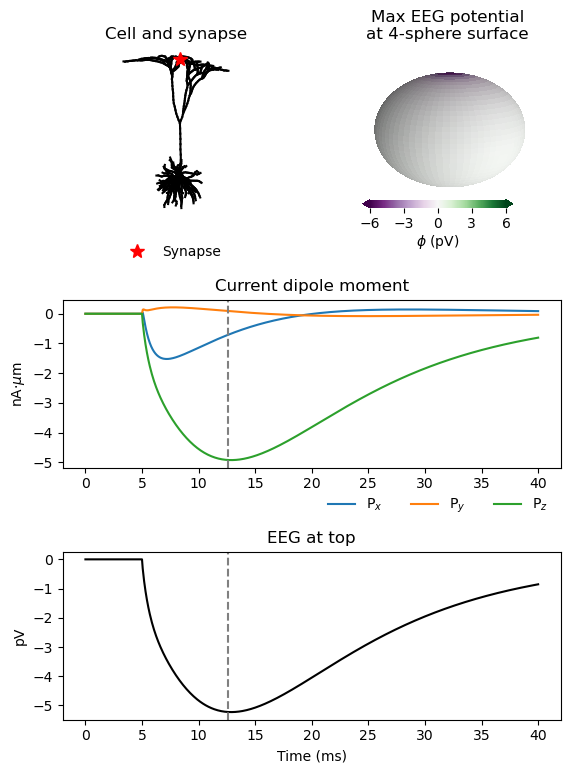

In [11]:
plt.close('all')
fig = plt.figure(figsize=[6, 8])
fig.subplots_adjust(left=0.15, hspace=0.5, right=0.98, top=0.95)

morph_ax = fig.add_subplot(321, aspect=1, frameon=False,
                            title="Cell and synapse",
                            xticks=[], yticks=[])
plot_cell_to_ax(cell, morph_ax, cell.synidx)

plot_EEG_sphere(fig, eeg, x_eeg, y_eeg, z_eeg)

ax_p = fig.add_subplot(
    312,
    title="Current dipole moment",
    ylabel=r"nA$\cdot\mu$m")
ax_p.plot(cell.tvec, P[0, :], label="P$_x$")
ax_p.plot(cell.tvec, P[1, :], label="P$_y$")
ax_p.plot(cell.tvec, P[2, :], label="P$_z$")
ax_p.axvline(cell.tvec[time_max], c='gray', ls='--')
ax_p.legend(frameon=False, ncol=4, bbox_to_anchor=[1, -0.1])

ax_eeg = fig.add_subplot(313, title="EEG at top", xlabel="Time (ms)",
                            ylabel='pV')
ax_eeg.plot(cell.tvec, eeg_top[0, :], 'k')

ax_eeg.axvline(cell.tvec[time_max], c='gray', ls='--')

# plt.savefig('example_EEG.pdf')
plt.show()